In [40]:
import pandas as pd
import numpy as np

data = pd.read_csv('../files/Week 08. data-mushroom.csv', delimiter=';').fillna('NAN')

In [41]:
data['y'] = data['class']
del data['class']
data['y'] = data['y'].apply(lambda x: 1 if x == 'p'  else 0)

In [42]:
from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [43]:
remove_columns = []
categorical_columns = []
numerical_columns = []

for c, t in data.iloc[:,:-1].iteritems():
    if t.dtype != np.float64:
        n_unique = len(t.unique())
        if n_unique == 1:
            remove_columns.append(c)
        else:
            categorical_columns.append(c)
        
    else:
        numerical_columns.append(c)

In [44]:
def transform(data, cs):
    return_list = []
    for c in cs:
        unique_values = {i : n for n,i in enumerate(data[c].unique())}
        num_df = data[c].apply(lambda x: unique_values[x])
        if len(unique_values) == 2:
            return_list.append(num_df.values.reshape(-1,1))
        else:
            return_list.append(np.eye(len(unique_values))[num_df])
            
    return np.concatenate(return_list, 1)

In [45]:
l = transform(data, categorical_columns)

In [46]:
features = np.concatenate([
    data[numerical_columns].values,
    l
], 1)

In [47]:
def ss_kfold_fn(data_x, data_y, scaling = True):
    kf = StratifiedKFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data_x, data_y)):
        
        scaler_x = StandardScaler()
        
        if scaling:
            
            train_x = scaler_x.fit_transform(data_x[train_idx])
            valid_x = scaler_x.transform(data_x[valid_idx])
            
        else:
            train_x = data_x[train_idx]
            valid_x = data_x[valid_idx]

        train_y = data_y[train_idx]
        valid_y = data_y[valid_idx]
        
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)

In [48]:
g = ss_kfold_fn(features, data.y.values)

In [49]:
((train_x, train_y), (valid_x, valid_y)), s = next(g)

In [50]:
Counter(train_y)

Counter({0: 21745, 1: 27110})

In [51]:
Counter(valid_y)

Counter({1: 6778, 0: 5436})

In [52]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state= 0)
path = model.cost_complexity_pruning_path(train_x, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [53]:
model.fit(train_x, train_y)

DecisionTreeClassifier(random_state=0)

[Text(0.7946510914950543, 0.9772727272727273, 'X[74] <= 0.294\ngini = 0.494\nsamples = 48855\nvalue = [21745, 27110]'),
 Text(0.6561093826009405, 0.9318181818181818, 'X[41] <= 1.149\ngini = 0.453\nsamples = 31313\nvalue = [10836, 20477]'),
 Text(0.5405307483379277, 0.8863636363636364, 'X[47] <= 0.646\ngini = 0.404\nsamples = 26018\nvalue = [7306, 18712]'),
 Text(0.41315165396465053, 0.8409090909090909, 'X[112] <= 5.818\ngini = 0.324\nsamples = 20902\nvalue = [4250, 16652]'),
 Text(0.4027738365493757, 0.7954545454545454, 'X[1] <= -0.835\ngini = 0.307\nsamples = 20549\nvalue = [3897, 16652]'),
 Text(0.2756607750932382, 0.75, 'X[11] <= 1.458\ngini = 0.054\nsamples = 4102\nvalue = [115, 3987]'),
 Text(0.24971623155505107, 0.7045454545454546, 'X[5] <= 2.161\ngini = 0.045\nsamples = 4035\nvalue = [92, 3943]'),
 Text(0.23933841413977622, 0.6590909090909091, 'X[18] <= 1.506\ngini = 0.043\nsamples = 4031\nvalue = [88, 3943]'),
 Text(0.19782714447867683, 0.6136363636363636, 'X[19] <= 2.461\ngini

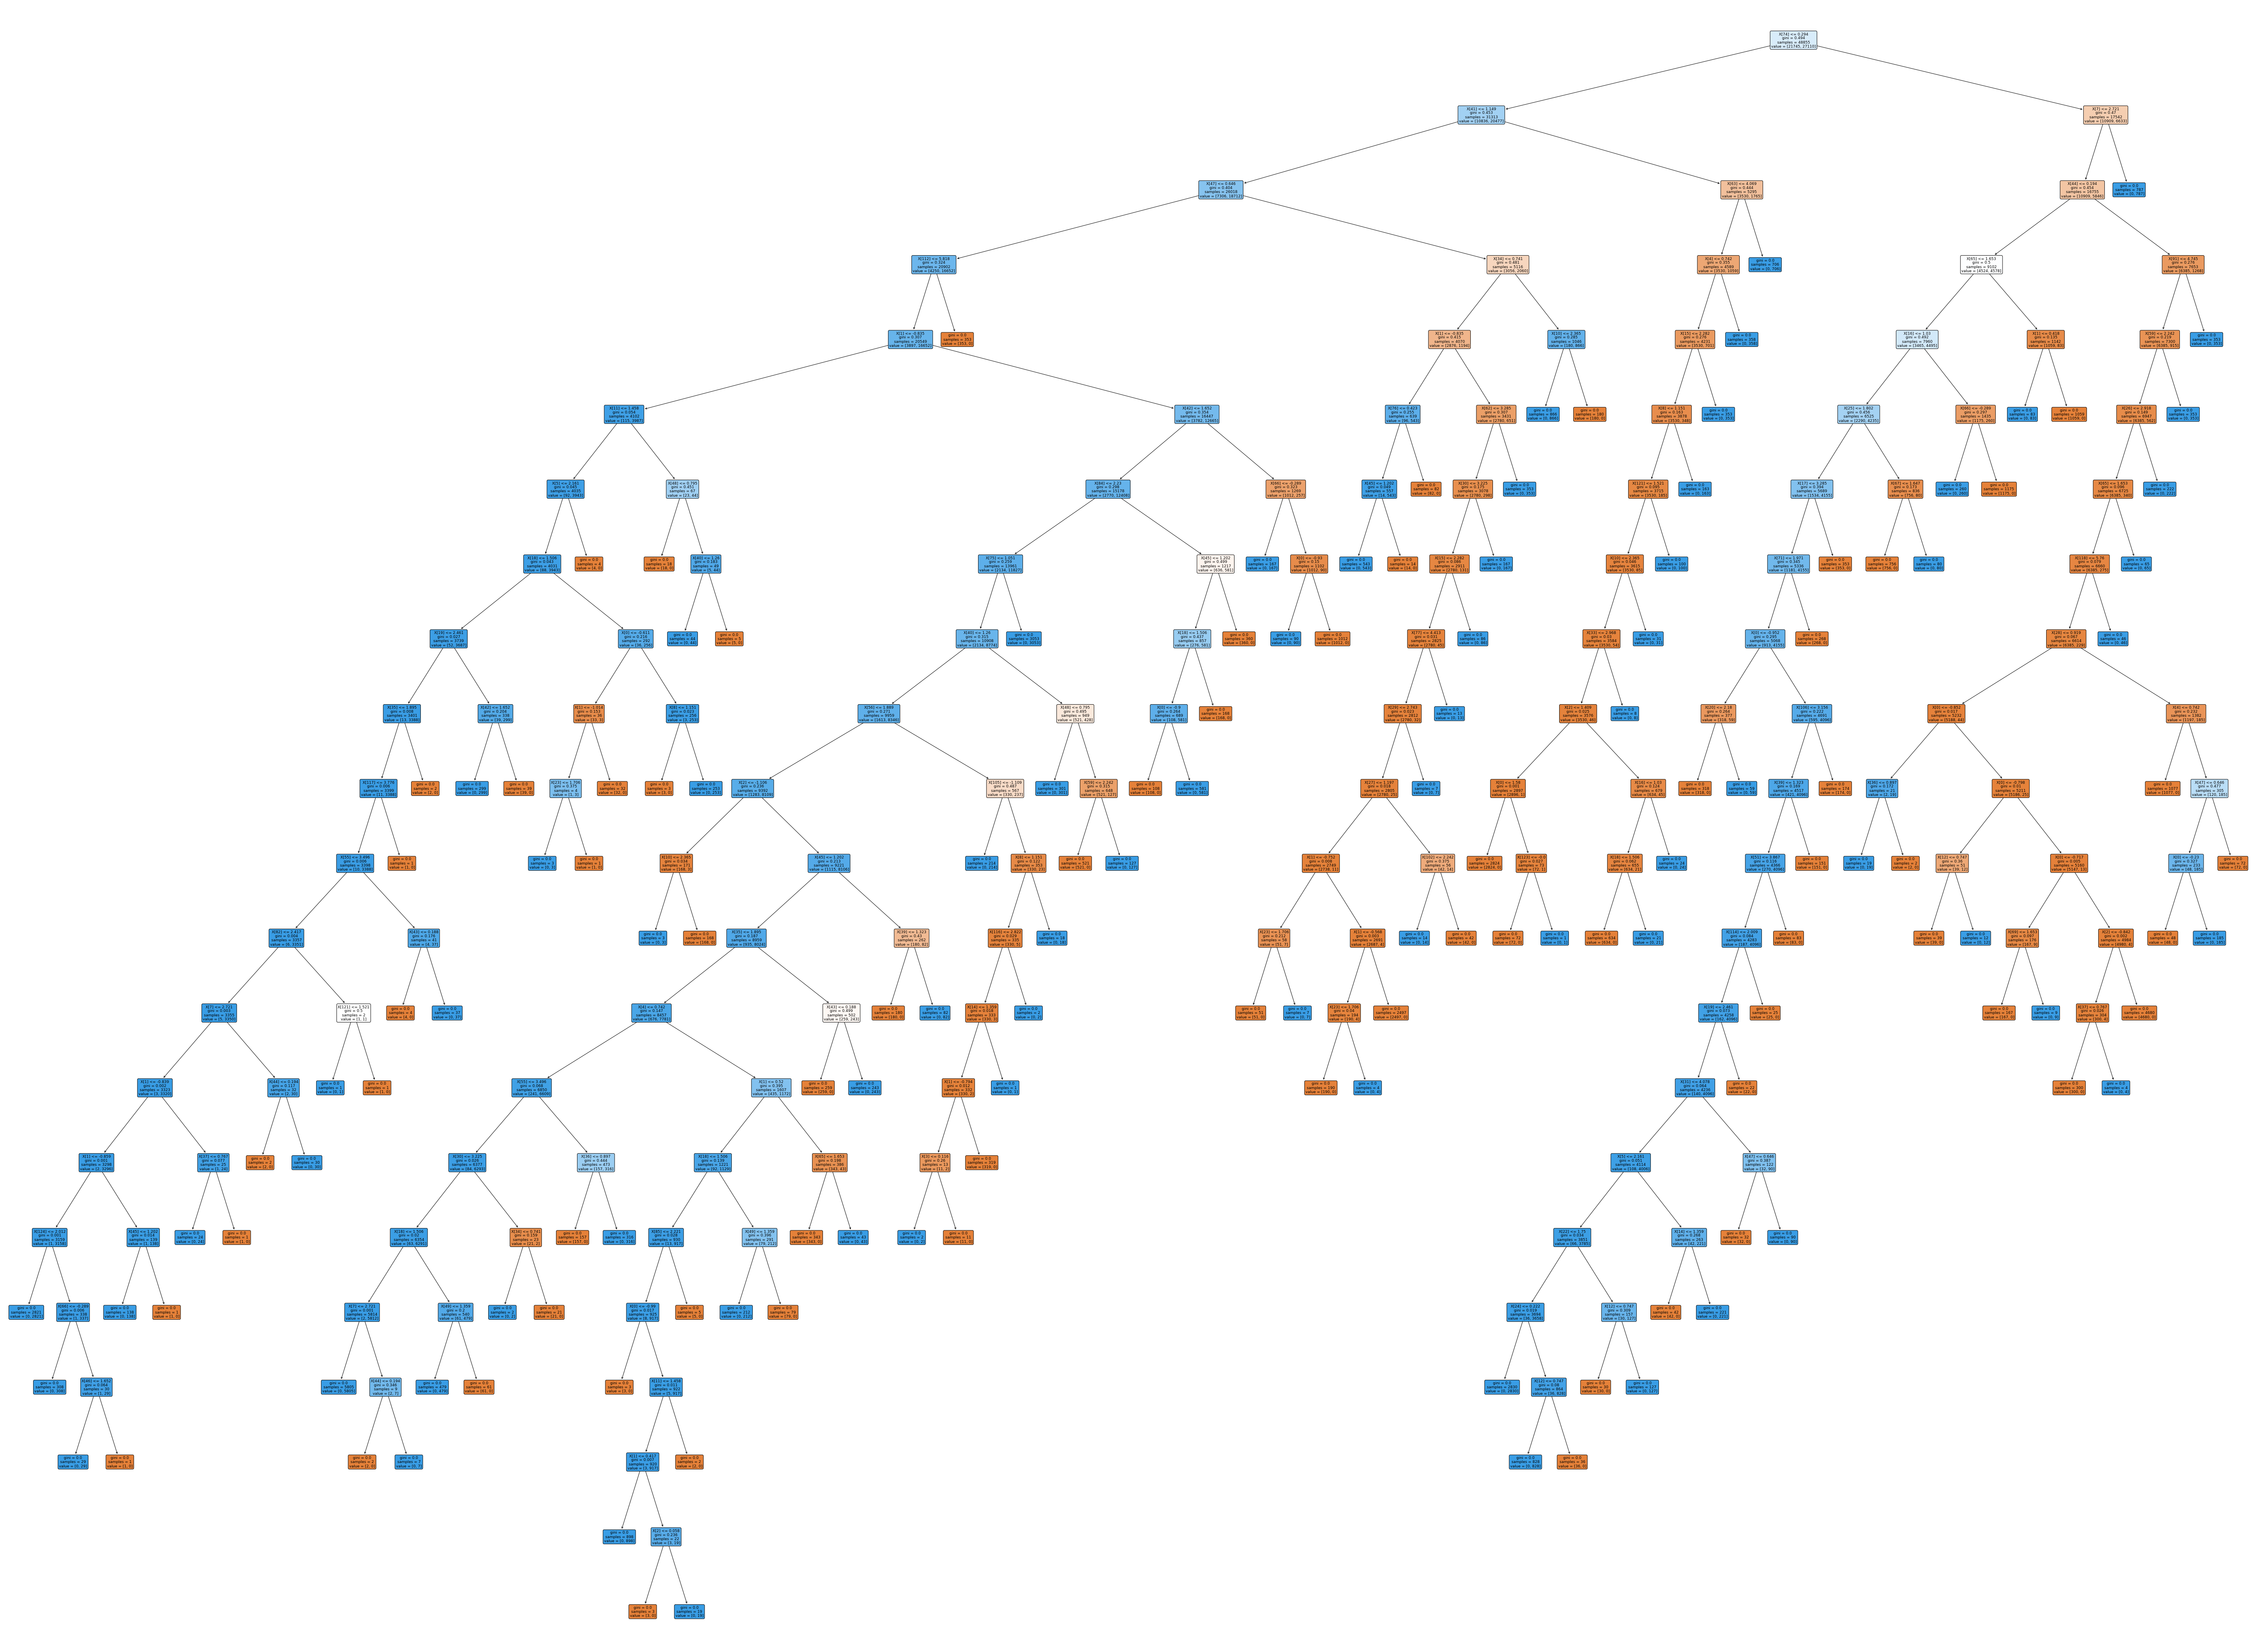

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sbn
from matplotlib import pyplot as plt
from sklearn import tree

plt.figure(figsize=(100, 75))
tree.plot_tree(model, impurity=True, filled=True, rounded=True)

In [55]:
model.get_n_leaves()

144

In [56]:
model.get_depth()

21

In [57]:
logits = model.predict(valid_x)

<AxesSubplot:>

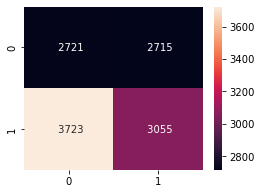

In [58]:
CM = confusion_matrix(valid_y, logits)

fig,ax = plt.subplots(1,1, figsize = (4,3))
sbn.heatmap(CM, annot = CM, ax = ax, fmt = '5g')

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

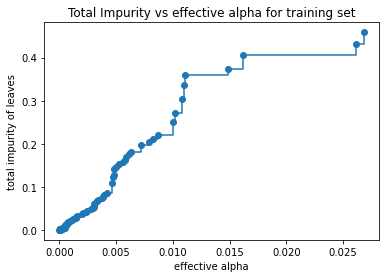

In [59]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [60]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_x, train_y)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.03501721705359928


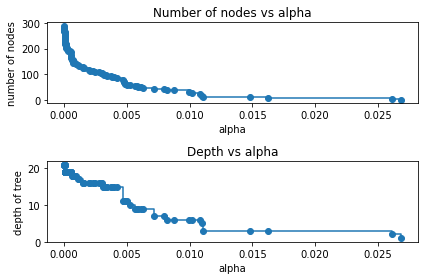

In [61]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

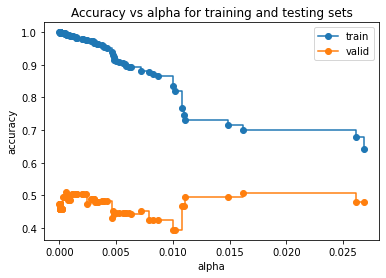

In [76]:
train_scores = [clf.score(train_x, train_y) for clf in clfs]
valid_scores = [clf.score(valid_x, valid_y) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

In [77]:
model = DecisionTreeClassifier(random_state = 0, ccp_alpha=0.03501721705359928)
model.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.03501721705359928, random_state=0)

[Text(0.5, 0.5, 'gini = 0.494\nsamples = 48855\nvalue = [21745, 27110]')]

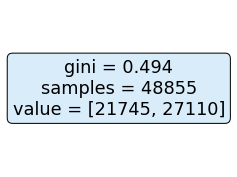

In [78]:
plt.figure(figsize=(4, 3))
tree.plot_tree(model, impurity=True, filled=True, rounded=True)

In [65]:
logits = model.predict(valid_x)

<AxesSubplot:>

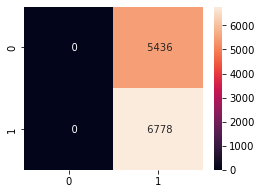

In [66]:
CM = confusion_matrix(valid_y, logits)

fig,ax = plt.subplots(1,1, figsize = (4,3))
sbn.heatmap(CM, annot = CM, ax = ax, fmt = '5g')

In [67]:
model.get_n_leaves()

1

In [68]:
model.get_depth()

0

In [69]:
model = DecisionTreeClassifier(random_state = 0, ccp_alpha=0.015)
model.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.015, random_state=0)

[Text(0.5555555555555556, 0.875, 'X[74] <= 0.294\ngini = 0.494\nsamples = 48855\nvalue = [21745, 27110]'),
 Text(0.3333333333333333, 0.625, 'X[41] <= 1.149\ngini = 0.453\nsamples = 31313\nvalue = [10836, 20477]'),
 Text(0.2222222222222222, 0.375, 'X[47] <= 0.646\ngini = 0.404\nsamples = 26018\nvalue = [7306, 18712]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.324\nsamples = 20902\nvalue = [4250, 16652]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.481\nsamples = 5116\nvalue = [3056, 2060]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.444\nsamples = 5295\nvalue = [3530, 1765]'),
 Text(0.7777777777777778, 0.625, 'X[7] <= 2.721\ngini = 0.47\nsamples = 17542\nvalue = [10909, 6633]'),
 Text(0.6666666666666666, 0.375, 'X[44] <= 0.194\ngini = 0.454\nsamples = 16755\nvalue = [10909, 5846]'),
 Text(0.5555555555555556, 0.125, 'gini = 0.5\nsamples = 9102\nvalue = [4524, 4578]'),
 Text(0.7777777777777778, 0.125, 'gini = 0.276\nsamples = 7653\nvalue = [6385, 1268]'),
 Text(0.8888888888888888, 0.37

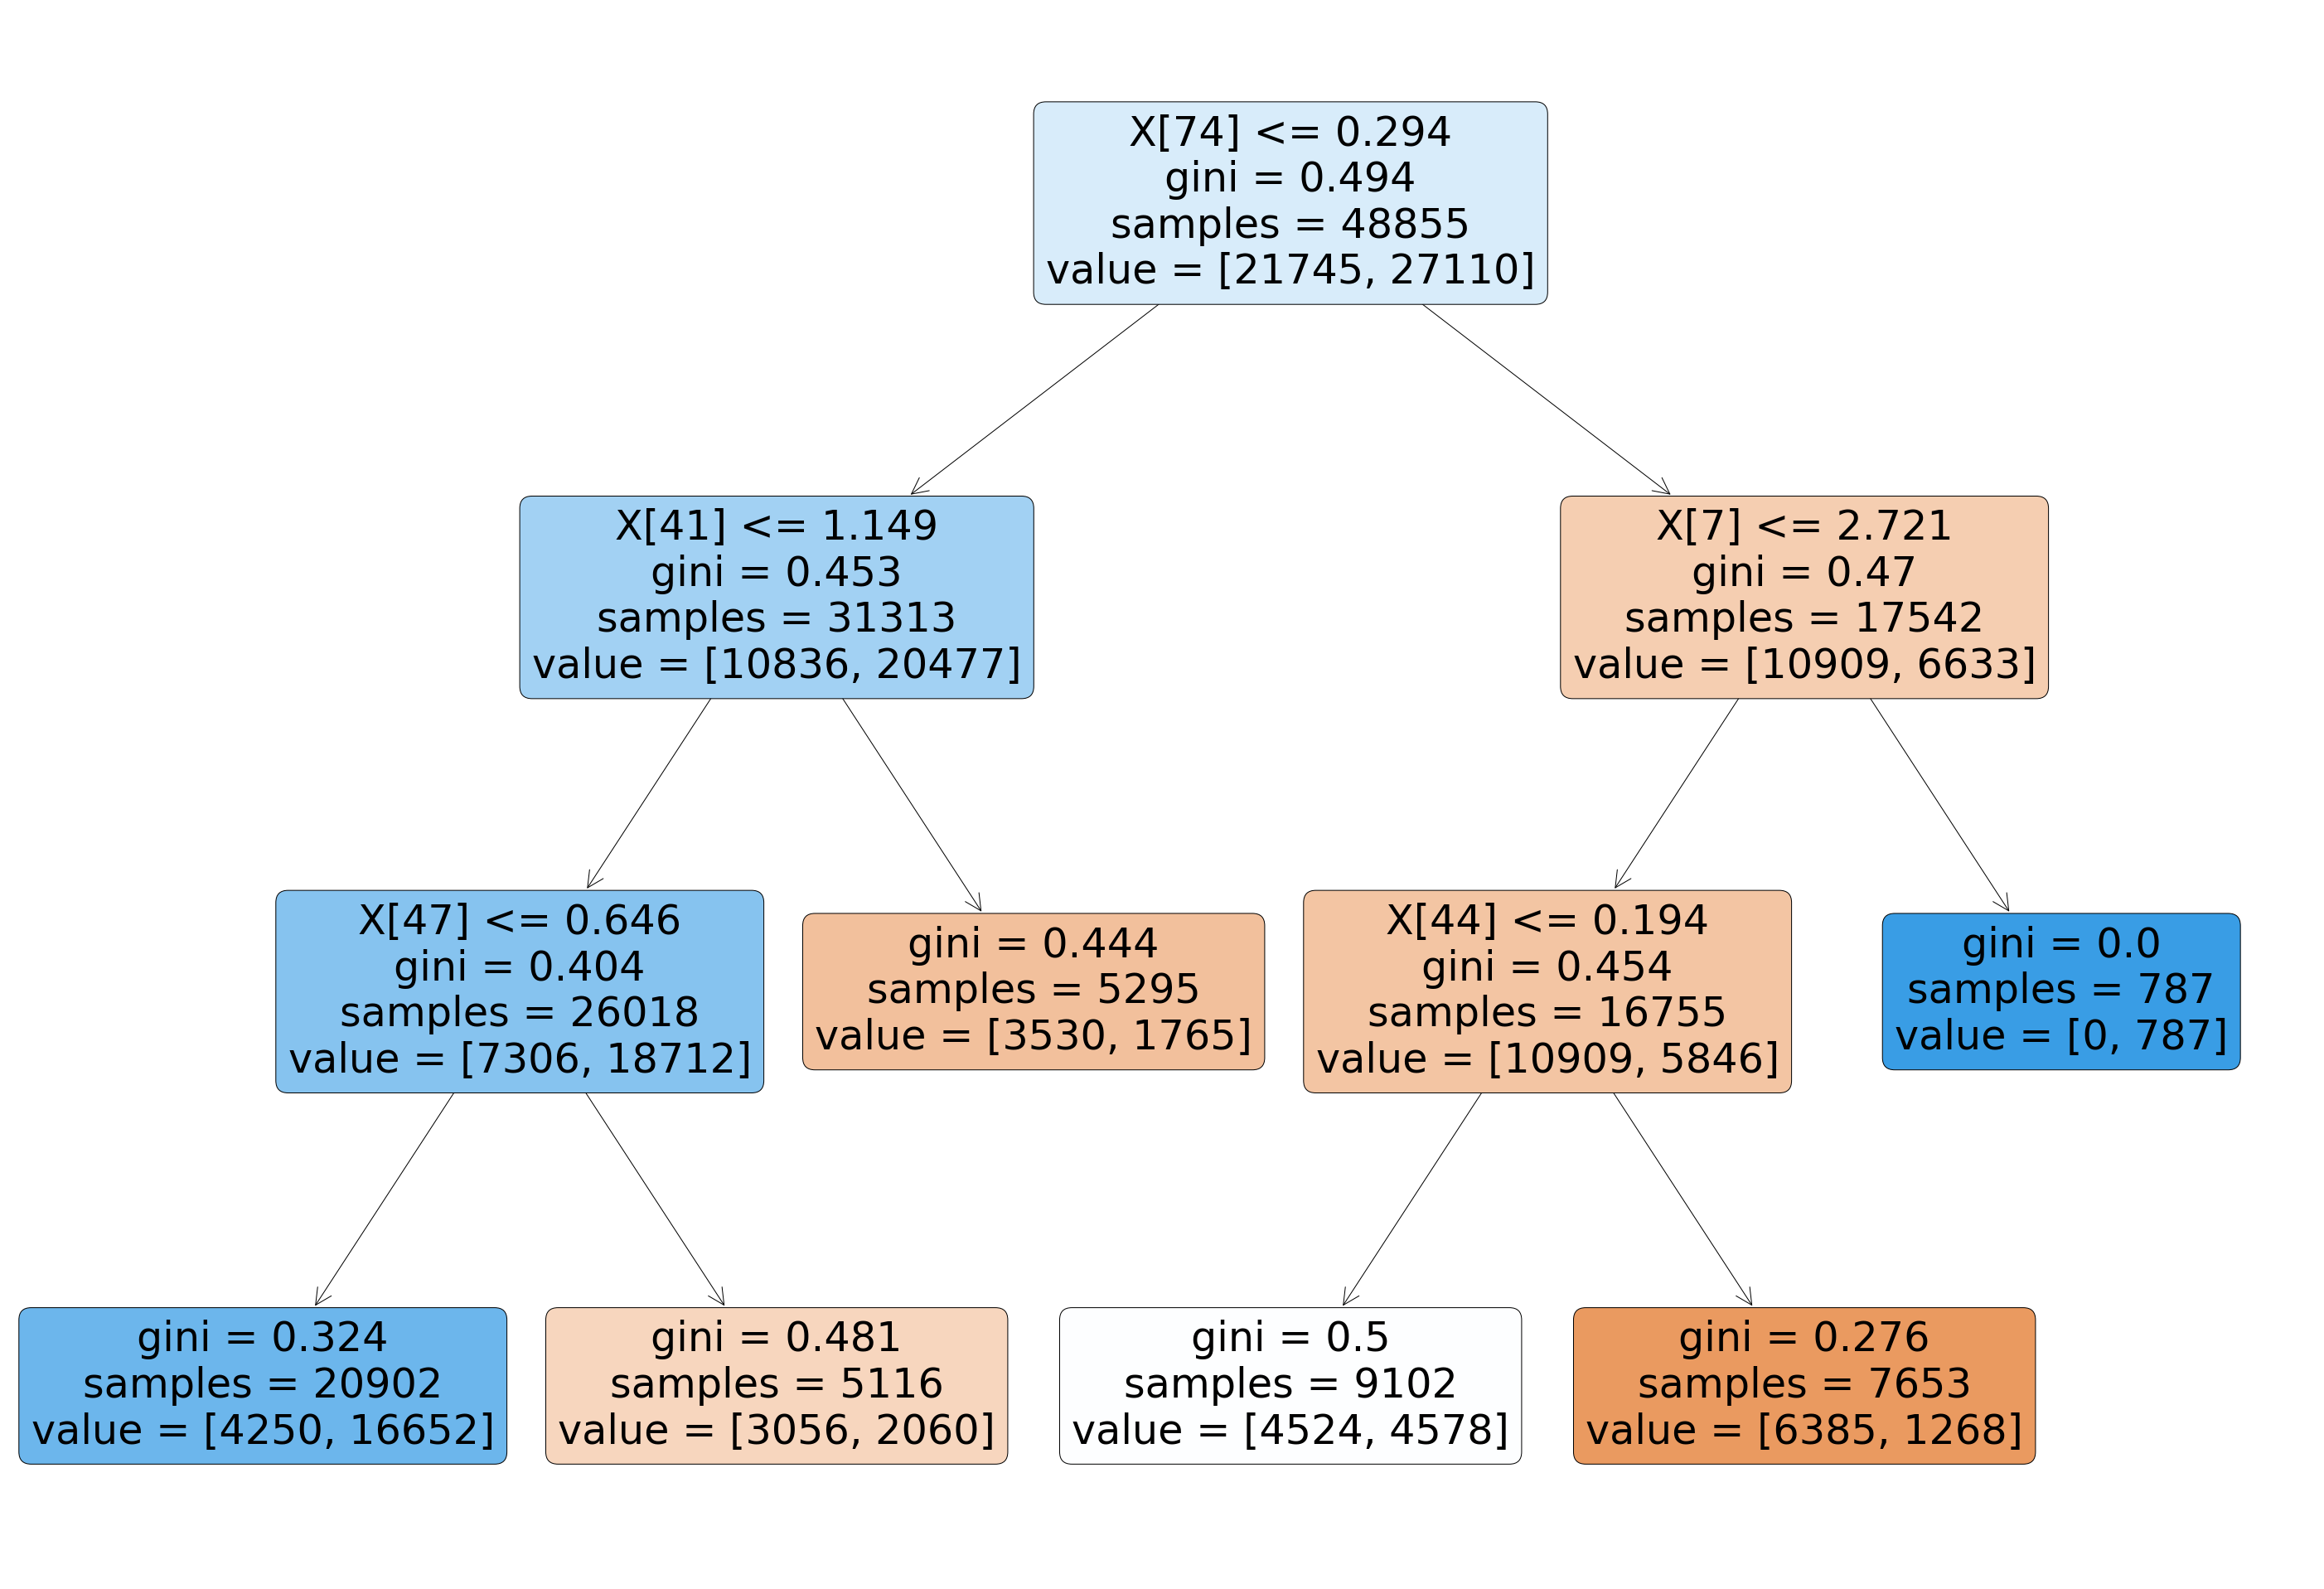

In [70]:
plt.figure(figsize=(50, 35))
tree.plot_tree(model, impurity=True, filled=True, rounded=True)

In [71]:
model.get_n_leaves()

6

In [72]:
model.get_depth()

3

In [73]:
logits = model.predict(valid_x)

<AxesSubplot:>

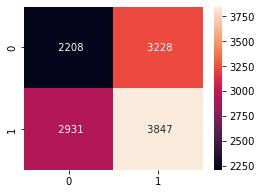

In [74]:
CM = confusion_matrix(valid_y, logits)

fig,ax = plt.subplots(1,1, figsize = (4,3))
sbn.heatmap(CM, annot = CM, ax = ax, fmt = '5g')